Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.
Цель: В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.
Снова предсказание цены квартиры, но на сей раз съемной :)

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных. 

Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

Обратите внимание на распределение целевой переменной.

Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :)
Критерии оценки: Максимум - 10 баллов

За качественную предобработку и визуализации - 5 баллов, за настройку и визуализацию коэффициентов моделей - еще 5 баллов.

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# 1. Загрузка данных

In [56]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [57]:
# Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review:
data = data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis = 1)
data.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


# 2. Исследование и первичная обработка

In [58]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [59]:
# Получается у нас 11 признаков, один из них "price" - целевой.


In [60]:
# признаки "neighbourhood_group", "neighbourhood", "room_type" - являются категориальными,
# посмотрим нет ли других признаков, которые можно отнести к категориальным. 
# К таковым будем относить те признаки, которые имеют менее 100 уникальных значений:
for i in data:
    if data[i].nunique() < 100:
        print(i, data[i].nunique())


neighbourhood_group 5
room_type 3
calculated_host_listings_count 47


In [61]:
data['neighbourhood_group'].unique()


array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [62]:
data['room_type'].unique()


array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [63]:
data['neighbourhood'].unique()


array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [64]:
data['neighbourhood'].value_counts()[:10]


Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

In [65]:
data['calculated_host_listings_count'].value_counts()[:20]


1      32303
2       6658
3       2853
4       1440
5        845
6        570
8        416
7        399
327      327
9        234
232      232
10       210
96       192
12       180
13       130
121      121
11       110
52       104
103      103
33        99
Name: calculated_host_listings_count, dtype: int64

In [66]:
# Признак 'calculated_host_listings_count' тоже будем считать категориальным:
# Итого 4 категориальных признака:
categories = ['neighbourhood_group', 'neighbourhood', 'room_type', 'calculated_host_listings_count']


In [67]:
data.describe()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [68]:
data.isnull().sum()


neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [69]:
# Признак "reviews_per_month" имеет пропуски:
data['reviews_per_month'].describe()


count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

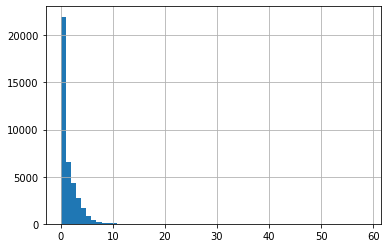

In [70]:
data['reviews_per_month'].hist(bins = 60);


In [71]:
data['reviews_per_month'].value_counts()


0.02     919
0.05     893
1.00     893
0.03     804
0.16     667
        ... 
10.23      1
8.94       1
6.04       1
9.21       1
10.67      1
Name: reviews_per_month, Length: 937, dtype: int64

In [72]:
# заменим пропуски на среднее значение признака:
data['reviews_per_month'] = data['reviews_per_month'].fillna(data['reviews_per_month'].mean())
data.isnull().sum()


neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [73]:
data[data['minimum_nights'] > 366].shape


(13, 11)

In [74]:
# Удалим все, что выше года:
data = data[data['minimum_nights'] < 366]


CPU times: user 12.7 s, sys: 159 ms, total: 12.9 s
Wall time: 12.9 s


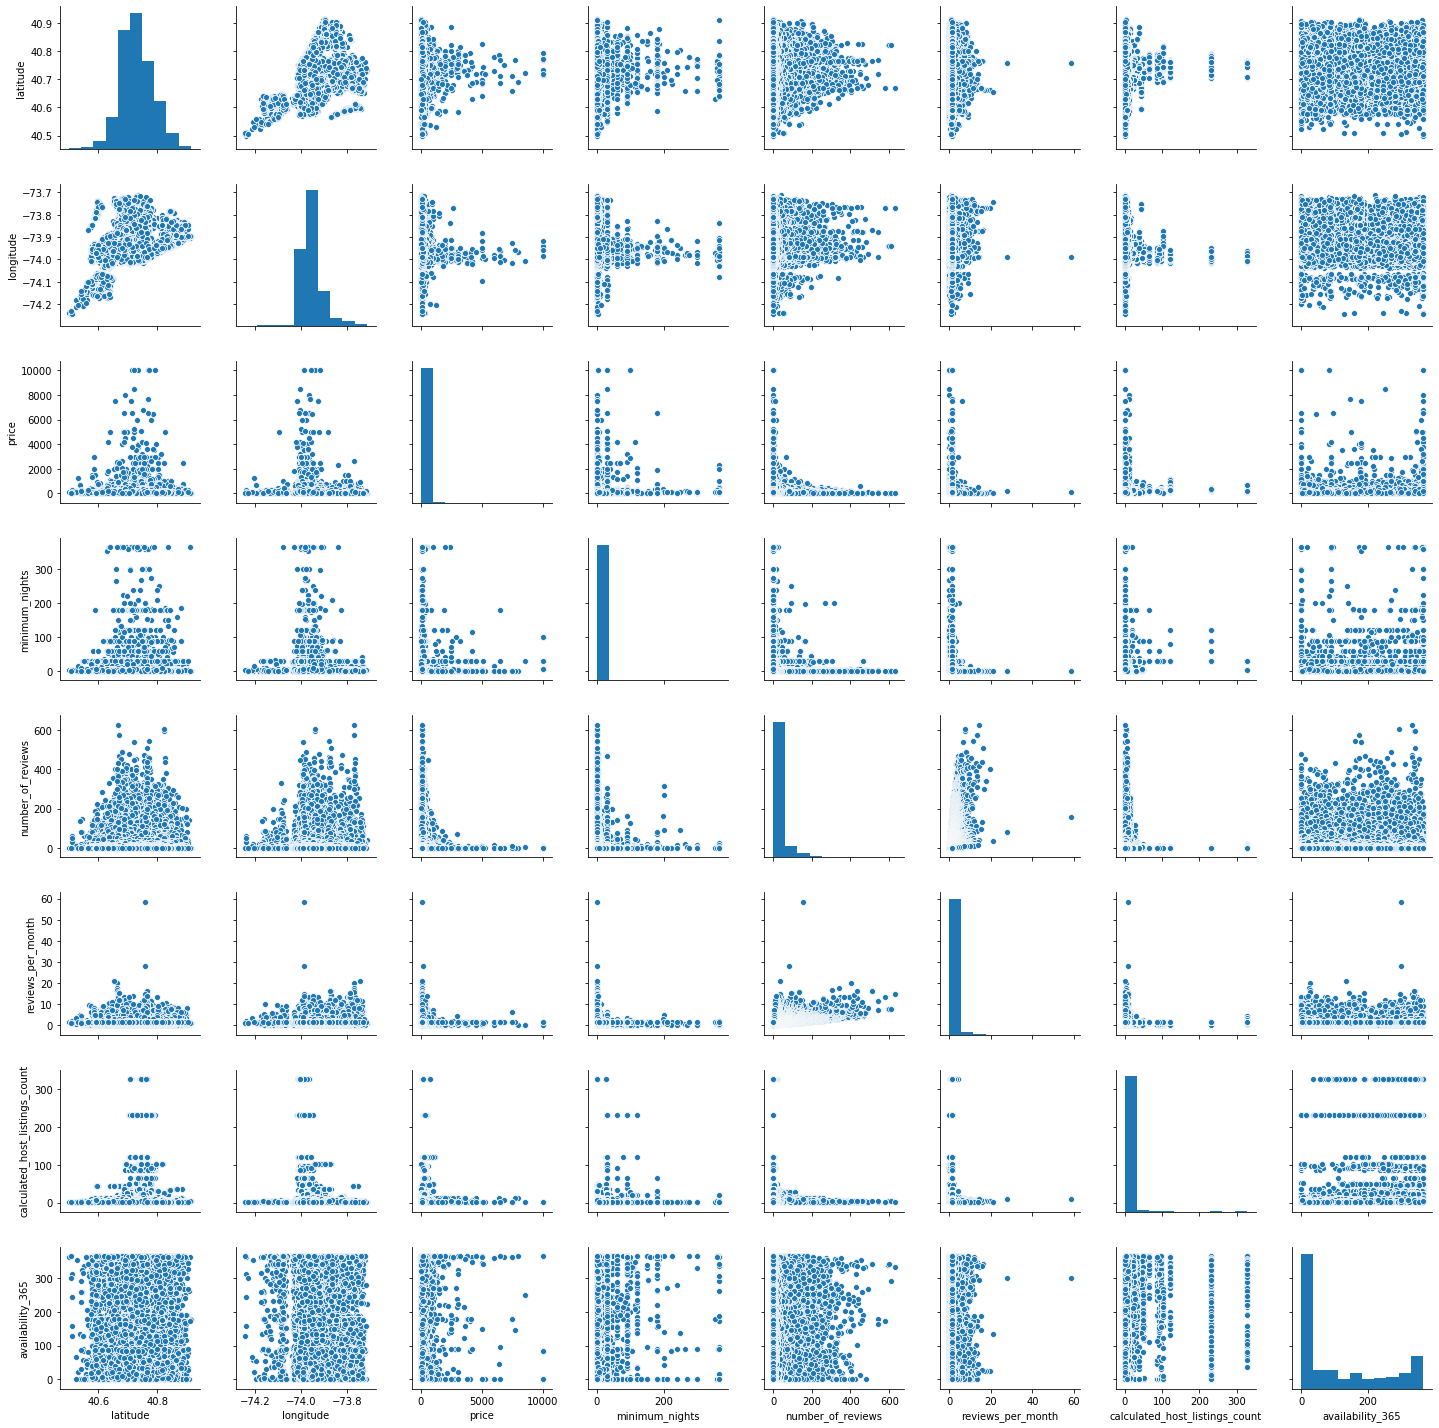

In [75]:
%%time
sns.pairplot(data);


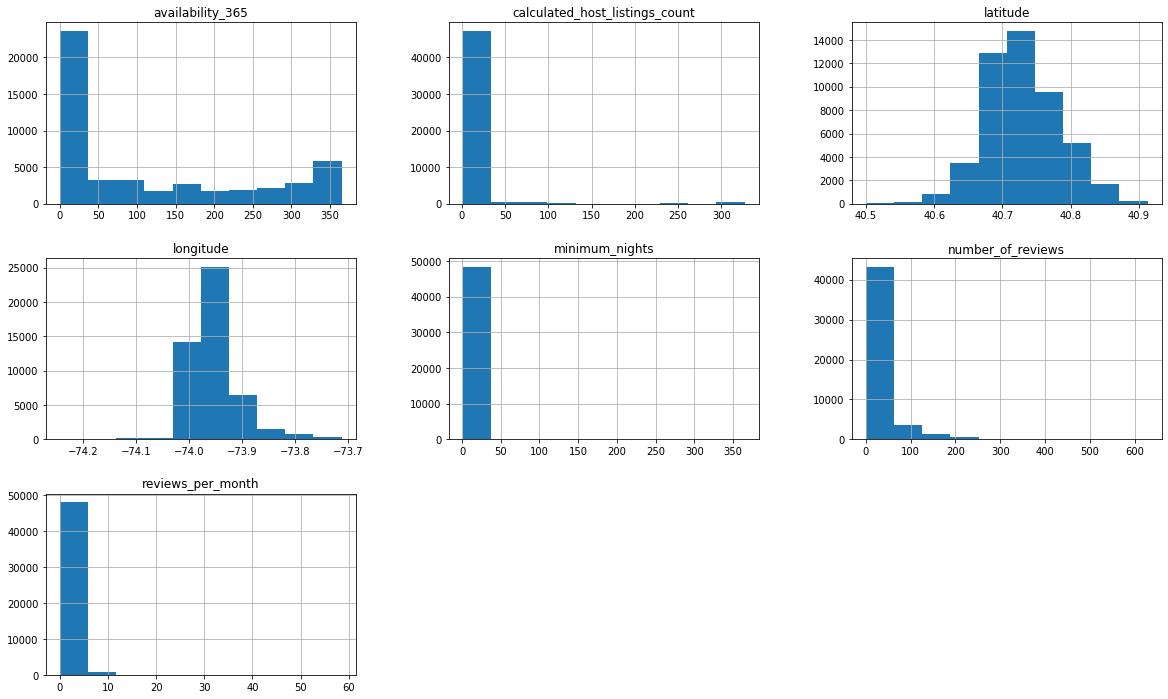

In [76]:
# Посмотрим на распределения признаков:
data.drop('price', axis = 1).hist(figsize = (20, 12));


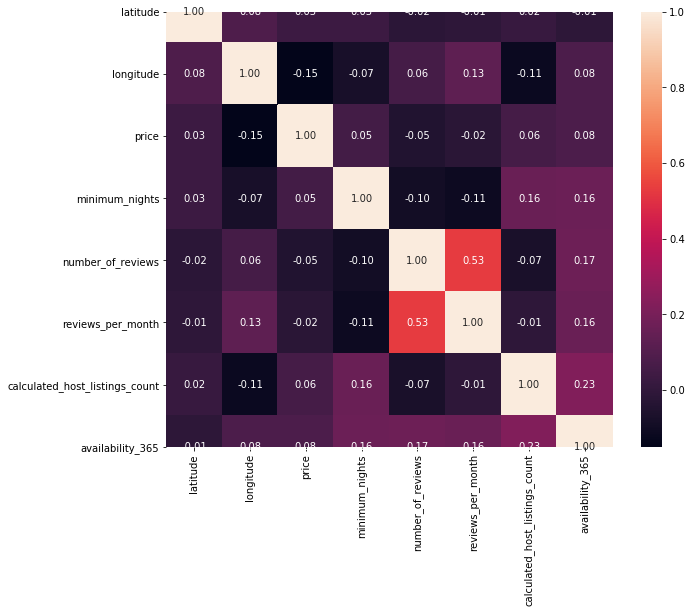

In [77]:
# Поищем коррелирующие признаки:
Corr = data.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(Corr, annot = True, fmt = '.2f');


In [78]:
# Коррелирующих признаков не обнаружено


### Рассмотрим целевой признак

In [79]:
# Удалим объекты с нулевым значением цены (prise)
selection = data['price'] == 0
data = data[~selection]
data.shape


(48870, 11)

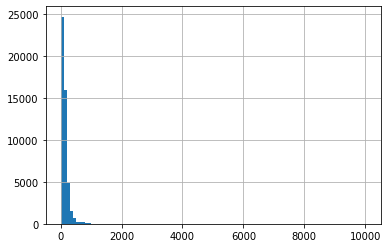

In [80]:
data['price'].hist(bins = 100);


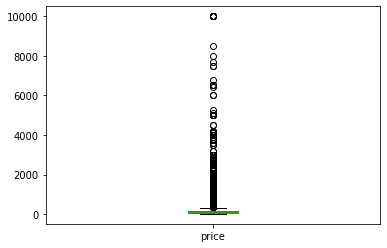

In [81]:
data['price'].plot.box();


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


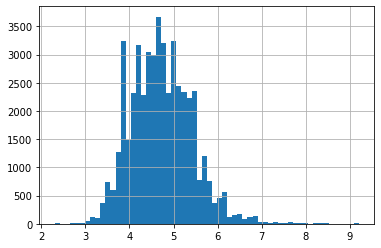

In [82]:
# очень большой хвост, пролагорифмируем:
data['price'] = np.log(data['price'])
data['price'].hist(bins = 60);


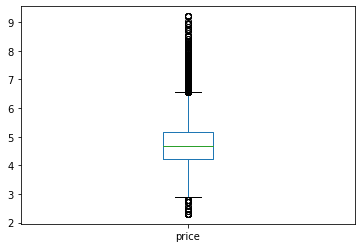

In [83]:
data['price'].plot.box();


In [84]:
# Все равно остается хвост - обрежем крайние значения на 2,5% и 97,5%:
data = data[data['price'] > data['price'].quantile(.025)]
data = data[data['price'] < data['price'].quantile(.975)]
data.shape


(46202, 11)

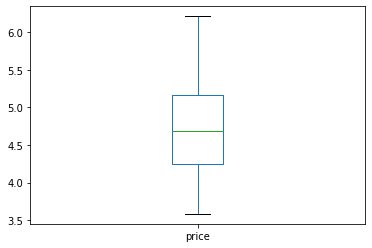

In [85]:
data['price'].plot.box();


# 3

In [86]:
# Разберемся с категориальными переменными:
for i in categories:
    data_categor = pd.get_dummies(data[i], drop_first = True, prefix = i)
    data = pd.concat([data.drop(i, axis = 1), data_categor], axis = 1)
data.head()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,calculated_host_listings_count_50,calculated_host_listings_count_52,calculated_host_listings_count_65,calculated_host_listings_count_87,calculated_host_listings_count_91,calculated_host_listings_count_96,calculated_host_listings_count_103,calculated_host_listings_count_121,calculated_host_listings_count_232,calculated_host_listings_count_327
0,40.64749,-73.97237,5.003946,1,9,0.210000,365,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.75362,-73.98377,5.416100,1,45,0.380000,355,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,5.010635,3,0,1.373221,365,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,40.68514,-73.95976,4.488636,1,270,4.640000,194,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,4.382027,10,9,0.100000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size = 0.3, random_state = 42)
print(df_train.shape, df_test.shape)


(32341, 277) (13861, 277)


In [88]:
from sklearn.preprocessing import StandardScaler

feature_for_scal = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                    'reviews_per_month', 'availability_365']

scaler = StandardScaler()
scaler.fit(df_train.loc[:, feature_for_scal]);

df_train_scale = scaler.transform(df_train.loc[:, feature_for_scal])
df_test_scale = scaler.transform(df_test.loc[:, feature_for_scal])

df_train.loc[:, feature_for_scal] = df_train_scale
df_test.loc[:, feature_for_scal] = df_test_scale


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [89]:
df_train.head()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,calculated_host_listings_count_50,calculated_host_listings_count_52,calculated_host_listings_count_65,calculated_host_listings_count_87,calculated_host_listings_count_91,calculated_host_listings_count_96,calculated_host_listings_count_103,calculated_host_listings_count_121,calculated_host_listings_count_232,calculated_host_listings_count_327
36519,0.477984,0.745730,4.248495,-0.353019,-0.485535,0.423253,1.781612,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18815,-0.315156,-0.304096,5.416100,-0.291413,0.608974,0.091772,-0.844646,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36313,0.463738,-0.977718,5.010635,0.016614,-0.329176,-0.260004,1.904478,0,1,0,...,0,0,0,0,0,0,0,0,0,0
47361,0.428031,-0.407612,5.010635,-0.353019,-0.530209,-0.000758,0.867797,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23566,0.097972,-0.123763,4.787492,-0.106597,-0.530209,-0.000758,-0.168884,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
df_test.head()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,calculated_host_listings_count_50,calculated_host_listings_count_52,calculated_host_listings_count_65,calculated_host_listings_count_87,calculated_host_listings_count_91,calculated_host_listings_count_96,calculated_host_listings_count_103,calculated_host_listings_count_121,calculated_host_listings_count_232,calculated_host_listings_count_327
18554,0.385109,3.082398,4.691348,-0.353019,3.401090,2.500083,1.581955,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12070,-1.313843,-0.045852,3.583519,0.509459,-0.217492,-0.598250,-0.729459,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9944,0.757535,-0.157028,5.323010,-0.291413,-0.016459,-0.517071,-0.844646,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13103,-0.034310,-0.622961,5.192957,-0.229808,-0.530209,-0.000758,-0.844646,0,1,0,...,0,0,0,0,0,0,0,0,0,0
41669,-0.312381,0.277171,4.204693,-0.291413,-0.329176,0.416488,1.804649,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
x_train = df_train.drop('price', axis = 1).get_values()
x_test = df_test.drop('price', axis = 1).get_values()
y_train = df_train['price']
y_test = df_test['price']


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.
/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  


### Сделаем константный прогноз:

In [92]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]


array([4.71620486, 4.71620486, 4.71620486, 4.71620486, 4.71620486])

In [93]:
np.exp(4.72596066)


112.83884608896257

In [94]:
# Константный прогноз стоимости равен $113 за сутки


In [95]:
# создадим функцию оценки результатов:
from sklearn import metrics  

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(np.exp(y_test), np.exp(y_pred)))
    print('MAPE:', mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)))
    pass


In [96]:
print_metrics(y_test, y_pred_naive)


MAE: 61.598744393982834
RMSE: 86.0968960023516
R2: -0.061848064941973924
MAPE: 52.8901132417543


In [97]:
# Получается, что наше наивное предположение ошибается в 53% случаев; на $62


### Построение моделей

In [98]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression()
model_regression.fit(x_train, y_train)
y_pred = model_regression.predict(x_test)

print_metrics(y_test, y_pred)


MAE: 39.495254288543734
RMSE: 61.16215205699276
R2: 0.46413806568052207
MAPE: 29.875999272975694


In [99]:
# Линейная регрессия улучшила наш наивный прогноз: MAPE сократился до 30% и MAE до $39


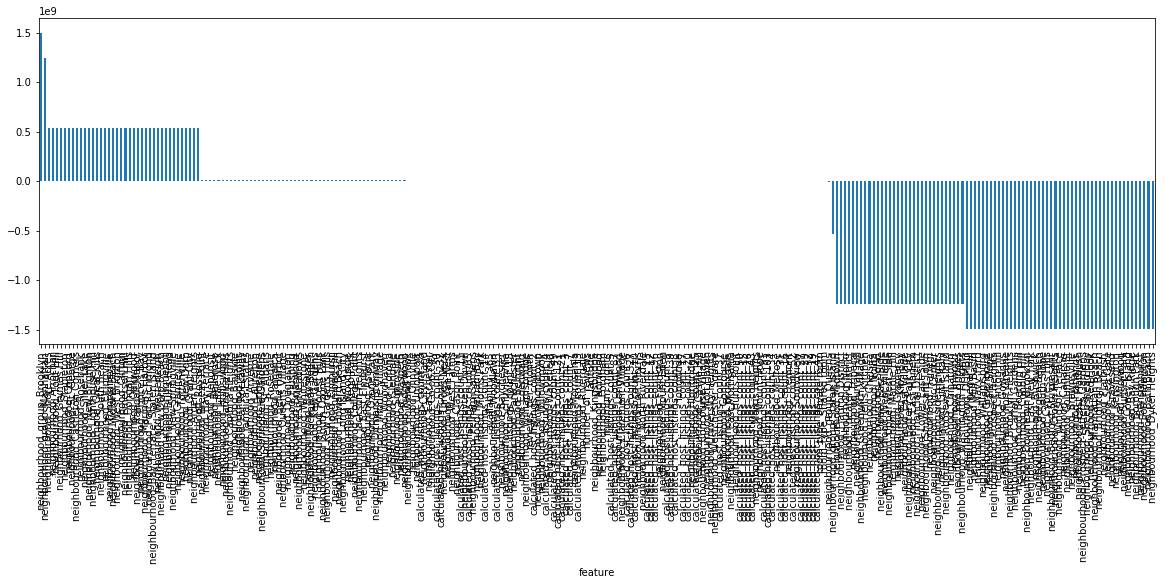

In [100]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


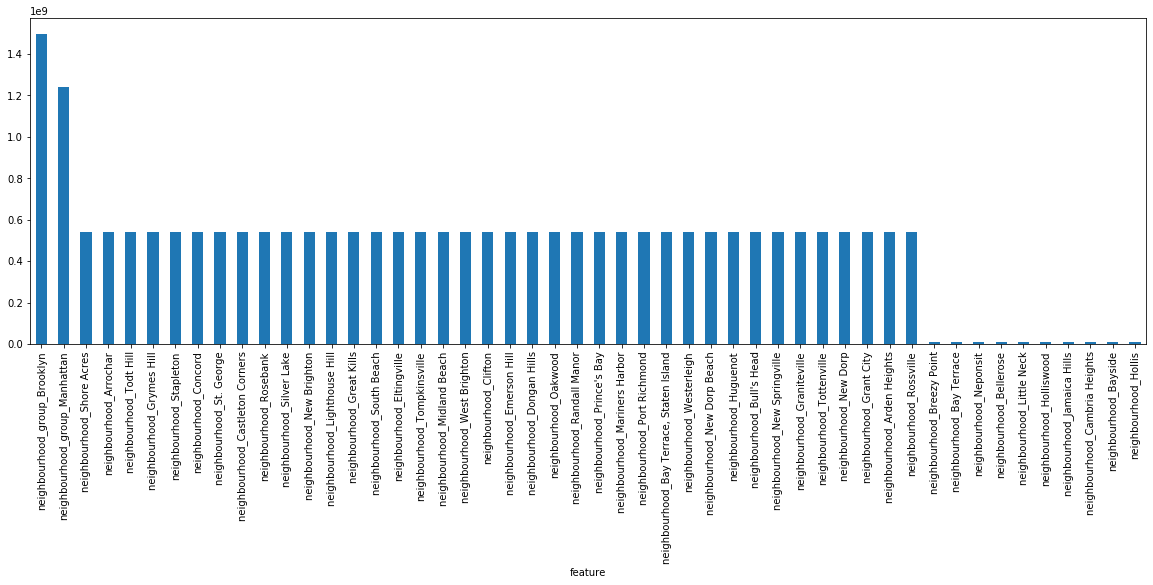

In [101]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][:50].plot(kind = 'bar', figsize = (20, 6));


In [103]:
# Незначительное положительное влияние оказывают Округа (особенно, Бруклин и Манхеттан) и районы.

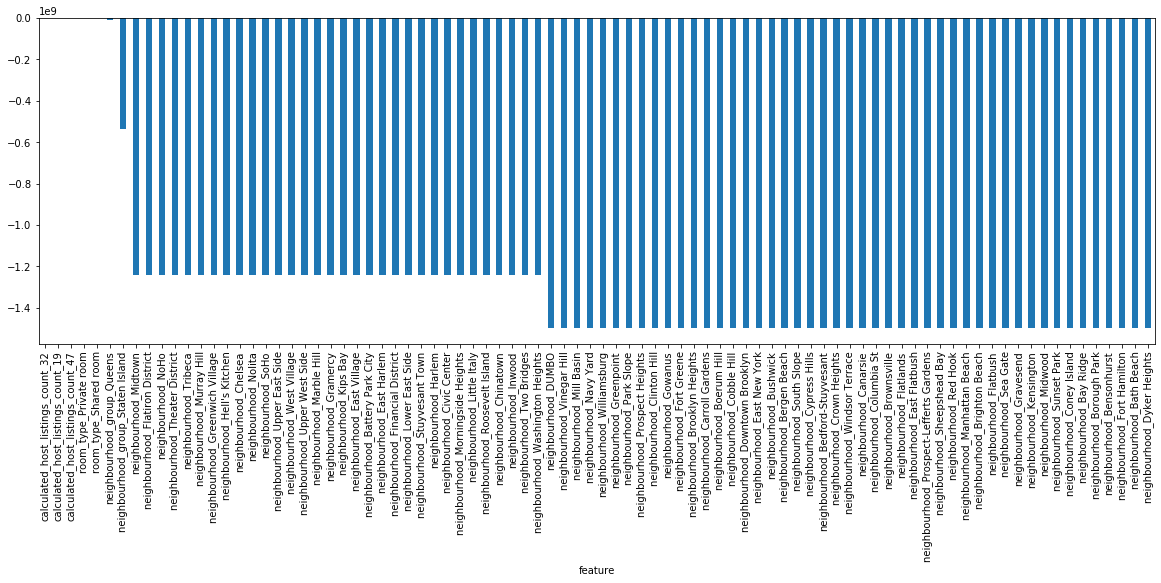

In [102]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][190:].plot(kind = 'bar', figsize = (20, 6));


In [104]:
# Отрицательное влияние на стоимость аренды оказывают определенные районы

In [105]:
from sklearn.linear_model import Lasso

model_lasso = Lasso()
model_lasso.fit(x_train, y_train)
y_pred_lasso = model_lasso.predict(x_test)

print_metrics(y_test, y_pred_lasso)


MAE: 61.59874439398316
RMSE: 86.09689600234981
R2: -0.06184806494192974
MAPE: 52.890113241758115


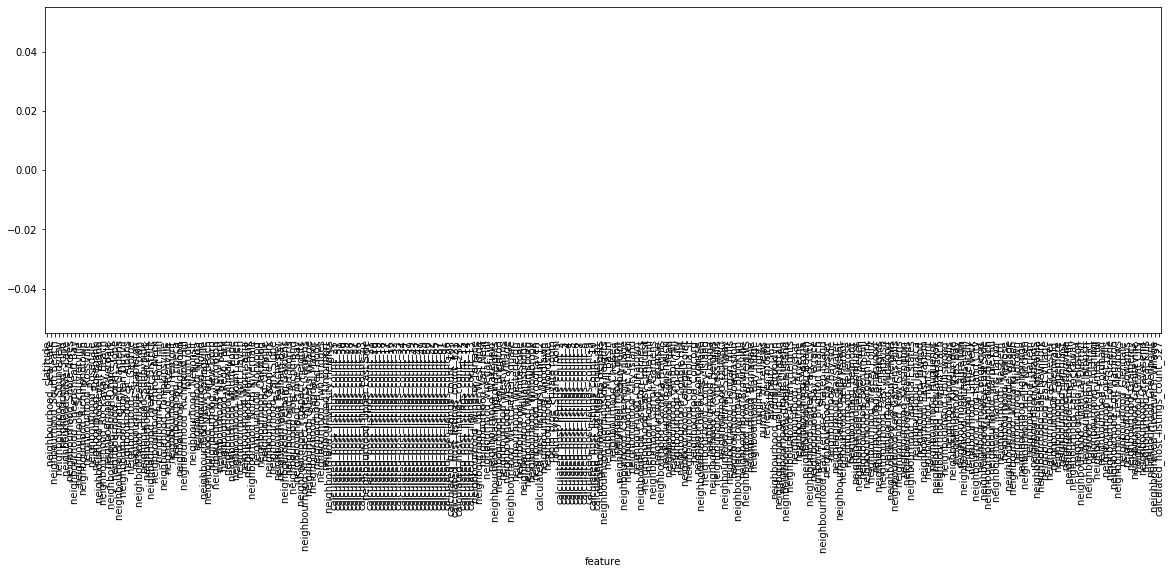

In [106]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_lasso.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


In [108]:
# Lasso с настройками по умолчанию занулила все признаки. Соответсвенно, результаты прогнозов сильно снизились.

In [113]:
# Попробуем подобрать лучший параметр alpha для Lasso:

param_grid = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1]}

model_lasso = Lasso() 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(x_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

y_pred_lasso = grid_cv_lasso.predict(x_test)

print_metrics(y_test, y_pred_lasso)


Лучшее значение параметра: {'alpha': 0.0001}
MAE: 39.511748602361706
RMSE: 61.20553497092495
R2: 0.4633776118329739
MAPE: 29.88429837320862


In [115]:
model_lasso = Lasso(alpha = 0.0001)
model_lasso.fit(x_train, y_train)
y_pred_lasso = model_lasso.predict(x_test)

print_metrics(y_test, y_pred_lasso)


MAE: 39.511748602361706
RMSE: 61.20553497092495
R2: 0.4633776118329739
MAPE: 29.88429837320862


In [111]:
# Получили почти такой же результат как у LinearRegression

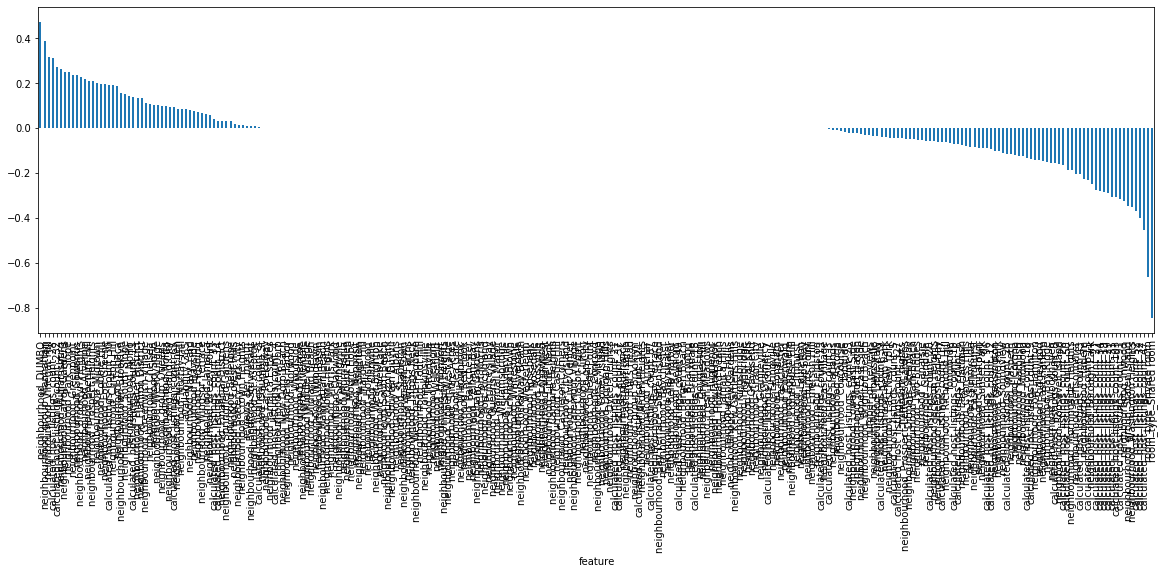

In [116]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_lasso.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


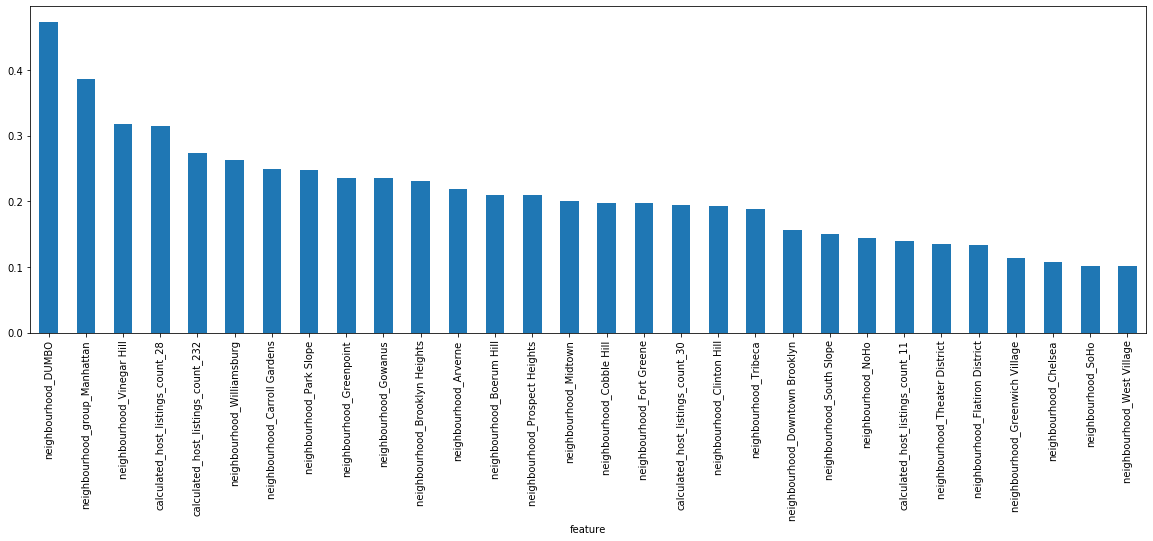

In [118]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_lasso.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][:30].plot(kind = 'bar', figsize = (20, 6));


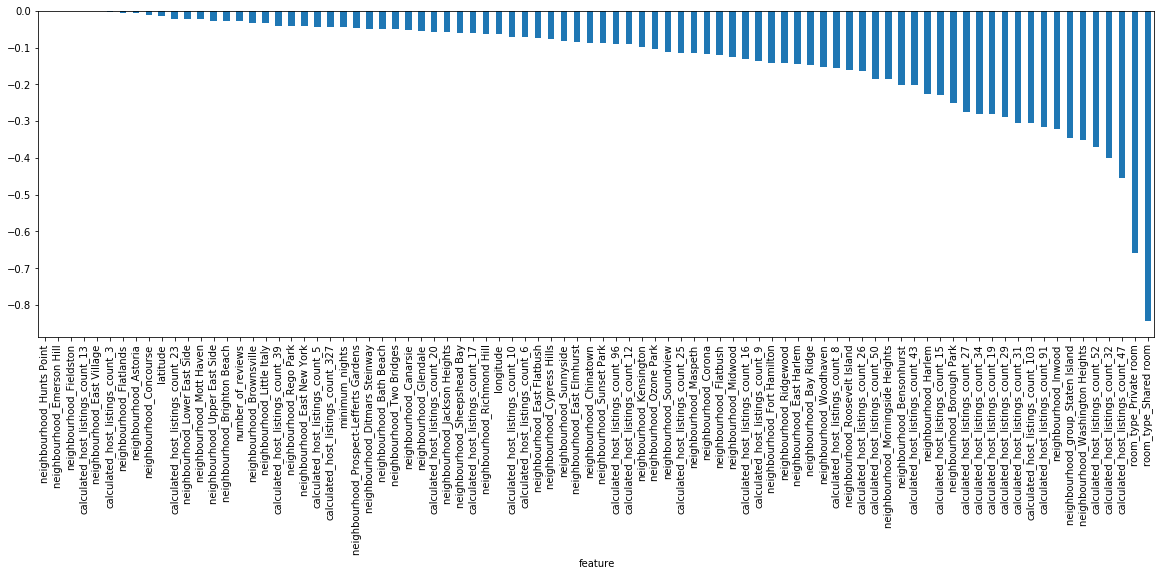

In [121]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": model_lasso.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][190:].plot(kind = 'bar', figsize = (20, 6));


In [ ]:
# Как и при LinearRegression видно малое влияние многих параметров.


In [123]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv = 5)
lasso_cv.fit(x_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

y_pred_lasso_cv = lasso_cv.predict(x_test)

print_metrics(y_test, y_pred_lasso_cv)


Лучшее значение параметра: 0.00019412583345618993
MAE: 39.68020103339728
RMSE: 61.424750663233496
R2: 0.459526760340739
MAPE: 30.036124128100333


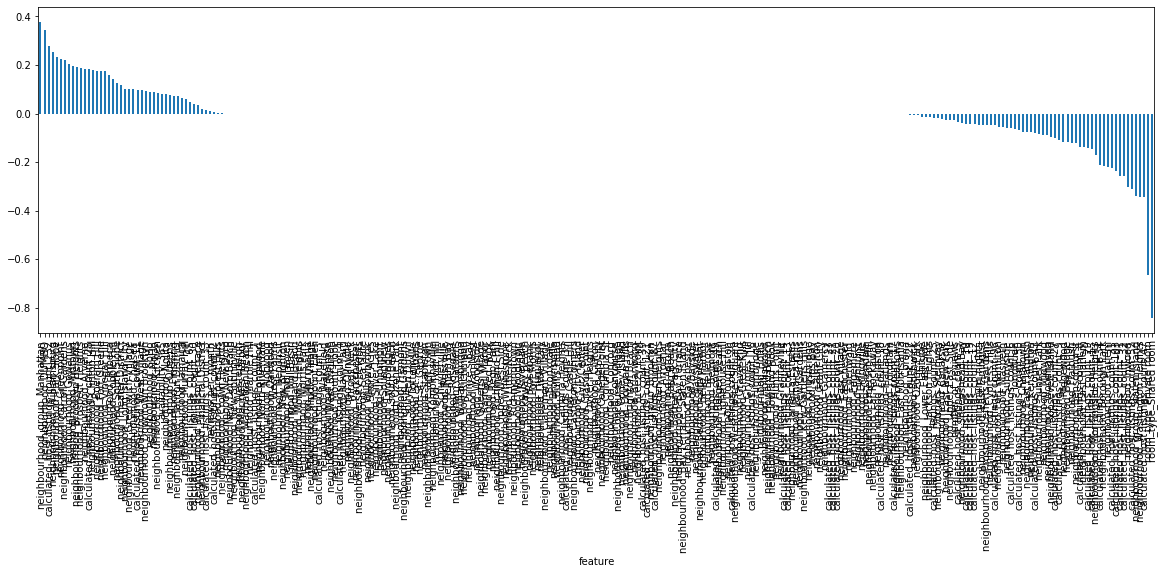

In [124]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


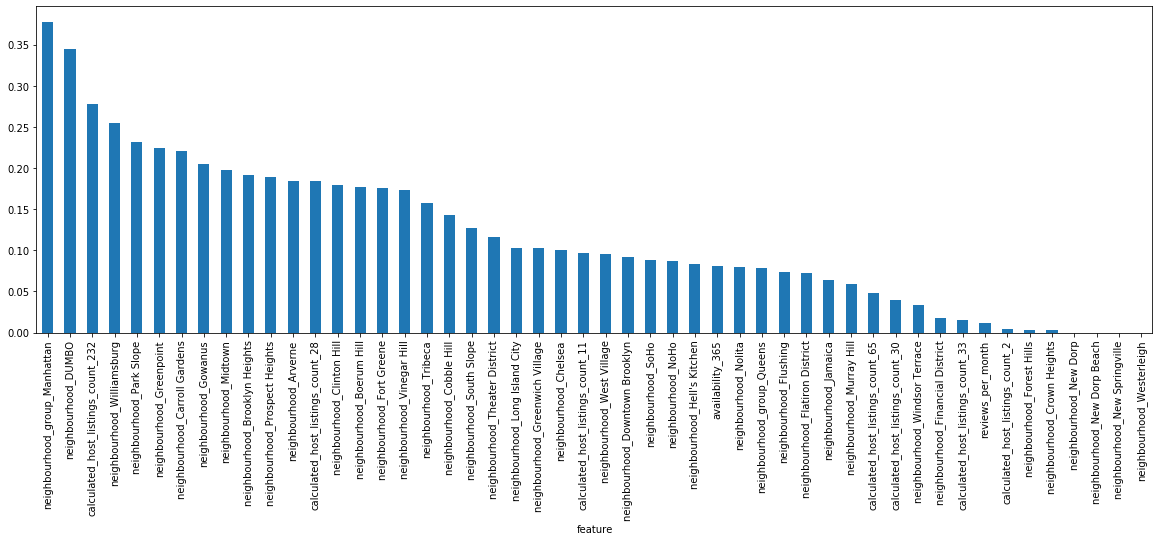

In [125]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][:50].plot(kind = 'bar', figsize = (20, 6));


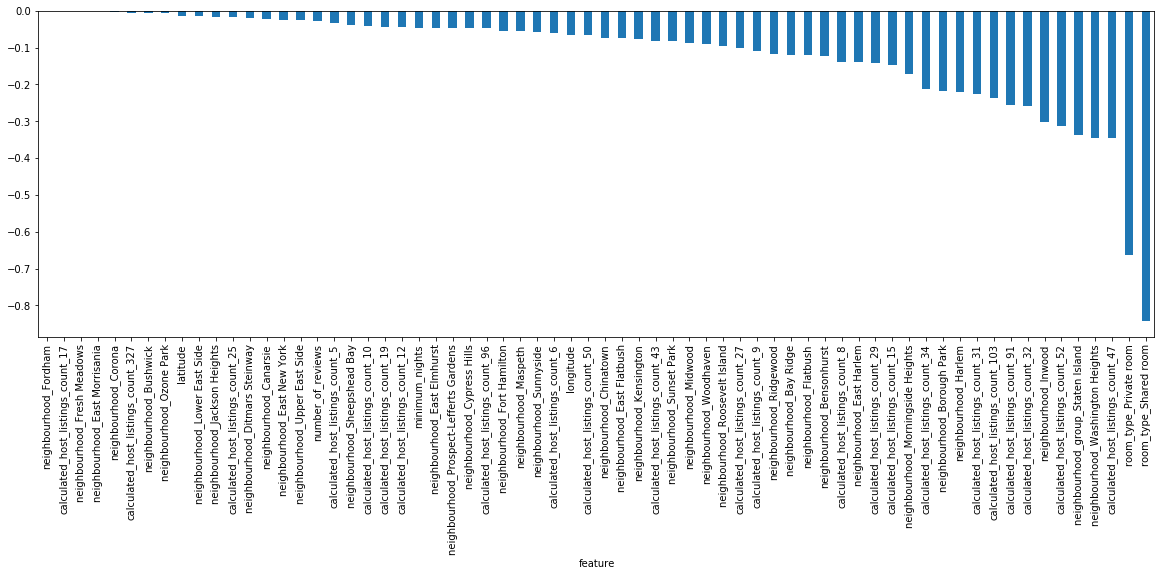

In [126]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][210:].plot(kind = 'bar', figsize = (20, 6));


In [127]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(cv = 5)
ridge_cv.fit(x_train, y_train)

y_pred_ridge_cv = ridge_cv.predict(x_test)

print_metrics(y_test, y_pred_ridge_cv)


MAE: 39.45073794690589
RMSE: 61.099981948883276
R2: 0.46522689795532135
MAPE: 29.833082102541226


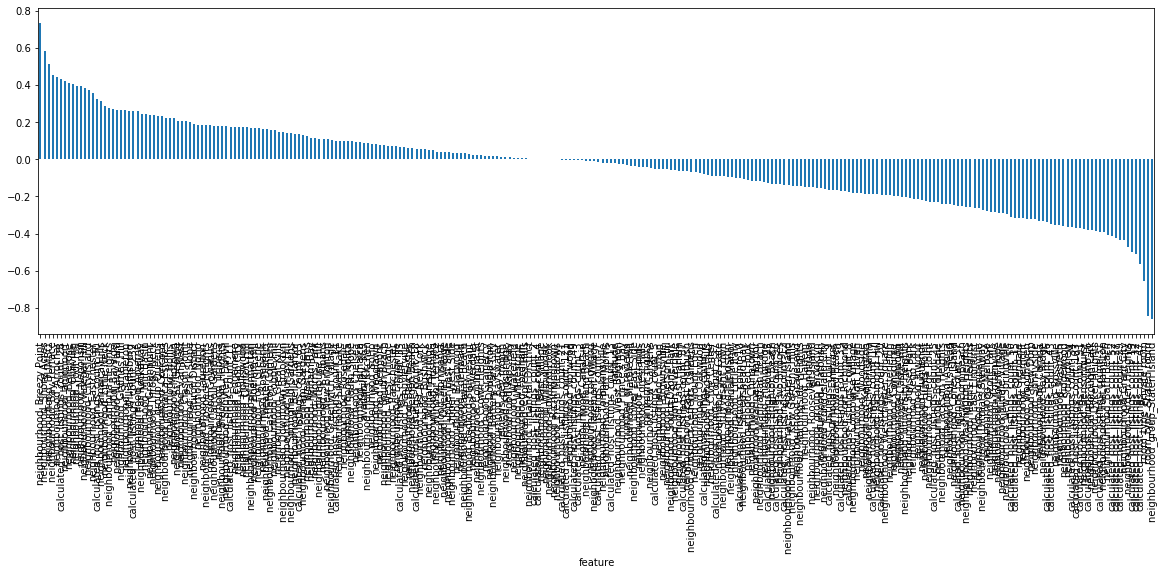

In [128]:
# Посмотрим на важность признаков:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


In [129]:
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(cv = 5)
elastic_cv.fit(x_train, y_train)

y_pred_elastic_cv = elastic_cv.predict(x_test)

print_metrics(y_test, y_pred_elastic_cv)


MAE: 39.73032857115742
RMSE: 61.49412160041511
R2: 0.4583052883295079
MAPE: 30.081476036247288


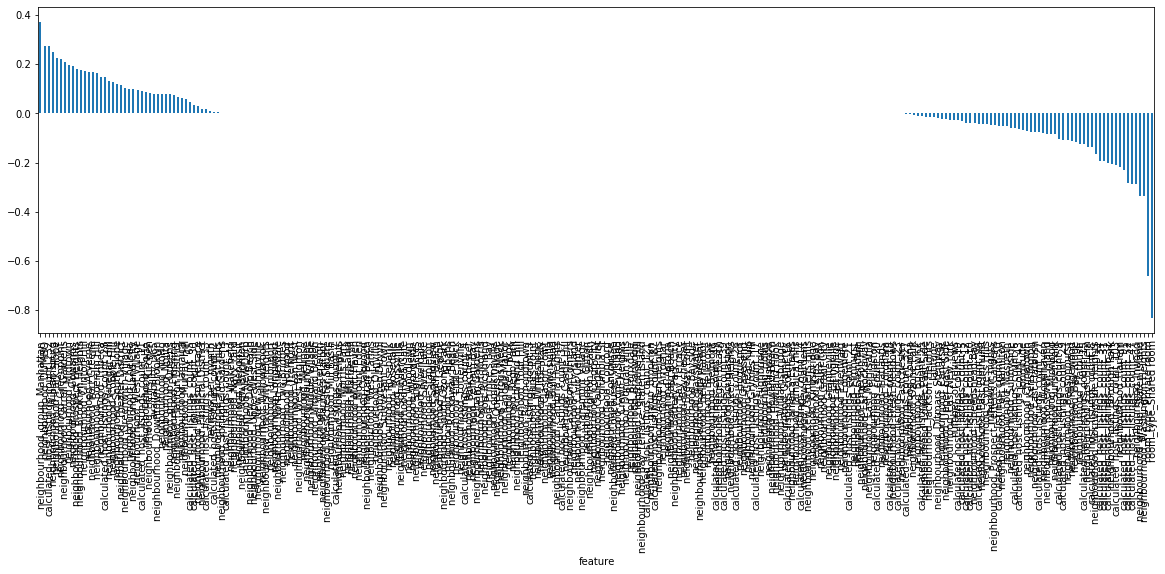

In [130]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": elastic_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot(kind = 'bar', figsize = (20, 6));


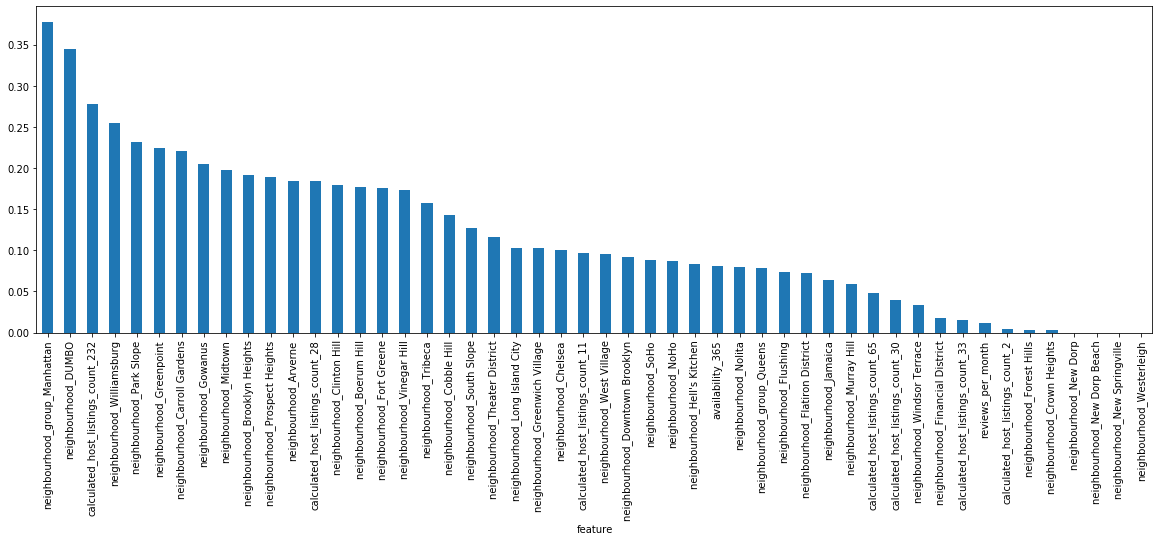

In [131]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][:50].plot(kind = 'bar', figsize = (20, 6));


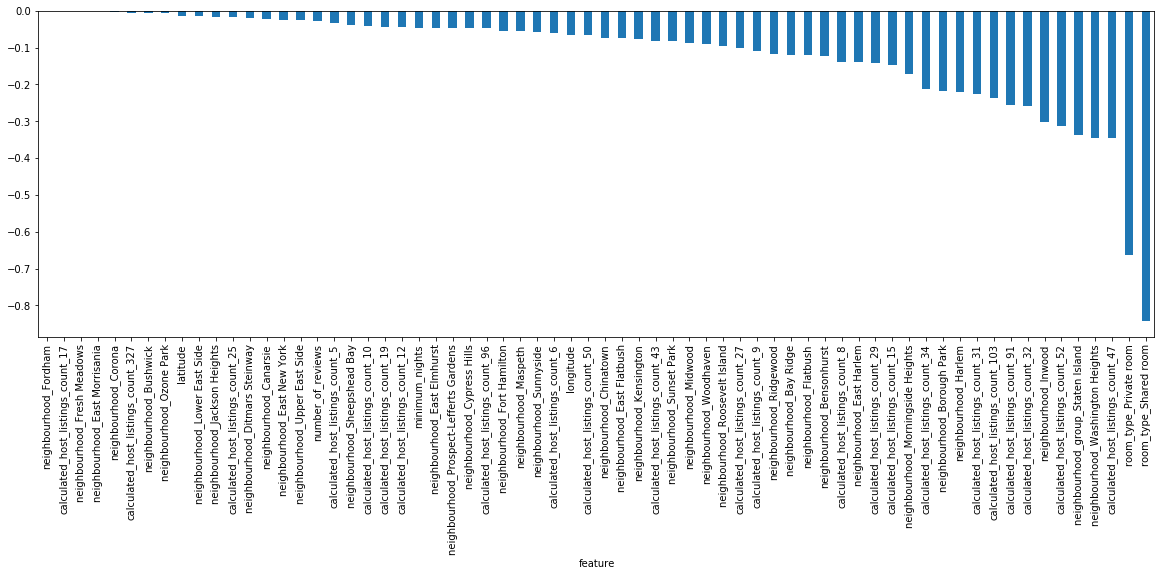

In [132]:
featureImportance = pd.DataFrame({"feature": data.drop('price', axis = 1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][210:].plot(kind = 'bar', figsize = (20, 6));


# Вывод

Все модели линейной регрессии показали достаточно похожие результаты.

Важность каждого признака у каждой модели достаточно низкая. 
Среди основных можно выделить Округ Манхеттен и район : Виллиамсбург, Думбо, Гриннпойнт и т.д.,

Так же модели выделили признак "Тип сдаваемой недвижимости", а именно Private и Shared.
Так же заметны  признаки группы "Сколько дней в году сдается объект".


# Создадим признак "Удаленность от центра":

In [133]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [134]:
# Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review:
data = data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis = 1)
data.shape


(48895, 11)

In [135]:
# заменим пропуски на среднее значение признака:
data['reviews_per_month'] = data['reviews_per_month'].fillna(data['reviews_per_month'].mean())
data.isnull().sum()


neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [136]:
# Координаты центра Нью-Йорка:
# Широта: 40.7142700°
# Долгота: -74.0059700°
latitude_centre = 40.7142700
longitude_center = - 74.0059700

data['distance_from_center'] = np.sqrt((latitude_centre - data['latitude']) ** 2 
                                       + (longitude_center - data['longitude']) ** 2)
data.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_from_center
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365,0.074756
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355,0.045180
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365,0.114379
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194,0.054625
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0,0.104584


In [137]:
data.shape


(48895, 12)

In [138]:
data = data.drop(['latitude', 'longitude'], axis = 1)
data.head()


,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_from_center
0,Brooklyn,Kensington,Private room,149,1,9,0.210000,6,365,0.074756
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.380000,2,355,0.045180
2,Manhattan,Harlem,Private room,150,3,0,1.373221,1,365,0.114379
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.640000,1,194,0.054625
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.100000,1,0,0.104584


In [139]:
data.shape


(48895, 10)

In [140]:
# Удалим объекты с нулевым значением цены (prise)
selection = data['price'] == 0
data = data[~selection]
data.shape


(48884, 10)

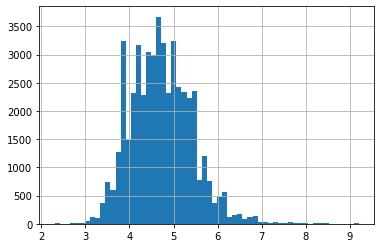

In [141]:
# очень большой хвост, пролагорифмируем:
data['price'] = np.log(data['price'])
data['price'].hist(bins = 60);


In [142]:
# и обрежем крайние значения на 2,5% и 97,5%:
data = data[data['price'] > data['price'].quantile(.025)]
data = data[data['price'] < data['price'].quantile(.975)]
data.shape


(46216, 10)

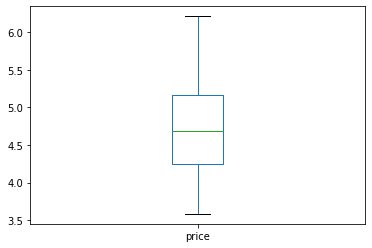

In [143]:
df_train['price'].plot.box();


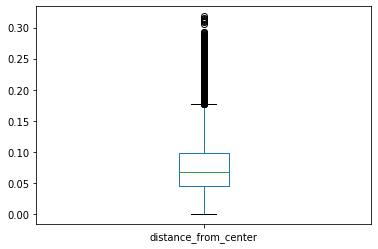

In [144]:
data['distance_from_center'].plot.box();


In [145]:
# Обрежем крайние значения на 5% и 95%:
data = data[data['distance_from_center'] > data['distance_from_center'].quantile(.05)]
data = data[data['distance_from_center'] < data['distance_from_center'].quantile(.95)]
data.shape


(41709, 10)

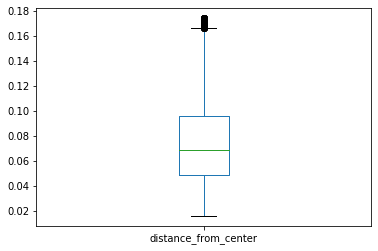

In [146]:
data['distance_from_center'].plot.box();


In [147]:
# Удалим все, что выше года:
data = data[data['minimum_nights'] < 366]


In [148]:
# Разберемся с категориальными переменными:
for i in categories:
    data_categor = pd.get_dummies(data[i], drop_first = True, prefix = i)
    data = pd.concat([data.drop(i, axis = 1), data_categor], axis = 1)
data.head()


,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,distance_from_center,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,...,calculated_host_listings_count_50,calculated_host_listings_count_52,calculated_host_listings_count_65,calculated_host_listings_count_87,calculated_host_listings_count_91,calculated_host_listings_count_96,calculated_host_listings_count_103,calculated_host_listings_count_121,calculated_host_listings_count_232,calculated_host_listings_count_327
0,5.003946,1,9,0.210000,365,0.074756,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.416100,1,45,0.380000,355,0.045180,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.010635,3,0,1.373221,365,0.114379,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.488636,1,270,4.640000,194,0.054625,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.382027,10,9,0.100000,0,0.104584,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size = 0.3, random_state = 42)
print(df_train.shape, df_test.shape)


(29187, 194) (12509, 194)


In [150]:
from sklearn.preprocessing import StandardScaler

feature_for_scal = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                    'availability_365', 'distance_from_center']

scaler = StandardScaler()
scaler.fit(df_train.loc[:, feature_for_scal]);

df_train_scale = scaler.transform(df_train.loc[:, feature_for_scal])
df_test_scale = scaler.transform(df_test.loc[:, feature_for_scal])

df_train.loc[:, feature_for_scal] = df_train_scale
df_test.loc[:, feature_for_scal] = df_test_scale


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [151]:
x_train = df_train.drop('price', axis = 1).values
x_test = df_test.drop('price', axis = 1).values
y_train = df_train['price']
y_test = df_test['price']


In [152]:
model_regression = LinearRegression()
model_regression.fit(x_train, y_train) 
y_pred = model_regression.predict(x_test)
print_metrics(y_test, y_pred)


MAE: 39.92485385105781
RMSE: 62.65178290860201
R2: 0.44265493059077476
MAPE: 29.682538936328495


In [153]:
model_simplelasso = Lasso()
model_simplelasso.fit(x_train, y_train)
y_pred_lasso = model_simplelasso.predict(x_test)
print_metrics(y_test, y_pred_lasso)


MAE: 61.24681400524868
RMSE: 86.65103061170343
R2: -0.06611673268188167
MAPE: 52.12049365320929


In [154]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
model_lasso = Lasso() 

grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(x_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

y_pred_lasso = grid_cv_lasso.predict(x_test)
print_metrics(y_test, y_pred_lasso)


Лучшее значение параметра: {'alpha': 0.0001}
MAE: 39.88853363307998
RMSE: 62.74613376036206
R2: 0.44097499186669464
MAPE: 29.633317874191484


In [155]:
lasso_cv = LassoCV(cv = 5)
lasso_cv.fit(x_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

y_pred_lasso_cv = lasso_cv.predict(x_test)
print_metrics(y_test, y_pred_lasso_cv)


Лучшее значение параметра: 0.00021491895361544651
MAE: 40.02040289758633
RMSE: 62.95080610004283
R2: 0.43732206351929204
MAPE: 29.764044519173815


In [156]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(cv = 5)
ridge_cv.fit(x_train, y_train)
y_pred_ridge_cv = ridge_cv.predict(x_test)

print_metrics(y_test, y_pred_ridge_cv)


MAE: 39.893458723766976
RMSE: 62.62984248832449
R2: 0.44304522256100953
MAPE: 29.647320701325086


In [157]:
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(cv = 5)
elastic_cv.fit(x_train, y_train)

y_pred_elastic_cv = elastic_cv.predict(x_test)

print_metrics(y_test, y_pred_elastic_cv)


MAE: 40.04918300826064
RMSE: 62.99751059849723
R2: 0.4364868291155417
MAPE: 29.793513567762776


# Вывод
Создание переменной "Расстояние от центра" не дало мне прибавки в качестве прогнозов(
